In [2]:
from sps4lat import model as mod
from sps4lat import preprocessing as pre
from sps4lat import optimize as opti
from sps4lat import utils as uti
from fgspectra import cross as fgc
from fgspectra import frequency as fgf
from fgspectra import power as fgp
import healpy as hp 
import numpy as np 
import matplotlib.pyplot as plt
import warnings
import scipy.optimize as opt
warnings.filterwarnings("ignore")


In [3]:
def _get_order_synfast(cl):
    shape = cl.shape
    N_freqs = shape[0]
    lst_idx = []
    for k in range(N_freqs):
        T=np.where(np.eye(N_freqs,k=k) == 1)
        lst = [[T[0][i],T[1][i]] for i in range(len(T[0]))]
        lst_idx.extend(lst)
    res = [cl[i,j,:] for i,j in lst_idx]
    return res

In [23]:
#### LOADING COVMAT ####
PATH = '/Users/benjamin_brng/Documents/Cambridge/PhD/SO/fg2_awg/analyses/202011_hilc_cal_err/'

with np.load(PATH+'fg_noise.npz') as data:
    fgs_covmat = data['TT']
    freqs=data['freq_TT']

with np.load(PATH+'cmb.npz') as data:
    cmb_covmat = data['TT']
    ells = data['ells']
    
dl=ells*(ells+1.)/2./np.pi
tot_covmat = cmb_covmat + fgs_covmat
nbins=len(ells)

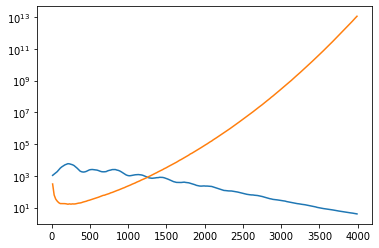

In [22]:
plt.figure()
plt.plot(ells, dl*cmb_covmat[:])
plt.plot(ells, dl*fgs_covmat[9,9,:])
plt.yscale('log')
plt.show()

In [26]:
par = {'nu_0' : 150.0, 'ell_0' : 3000, 'T_CMB' : 2.725, 'T_d' : 9.7,
       'a_tSZ' : 4.66, 'a_kSZ' : 1.60, 'a_p' : 6.87, 'beta_p' : 2.08,
       'a_c' : 6.10, 'beta_c' : 2.08, 'n_CIBC' : 1.20, 'xi' : 0.09, 
       'a_s' :3.50,'a_g' :0.88}

nred=np.zeros(len(freqs))
nred[:6] = np.array([100,39,230,1500,17000,31000])


[ 27.  39.  93. 145. 225. 280.]


In [5]:
#### MODEL OF THE COVMAT ####

## Noise ##
noise = mod.GroundBasedNoise(ell=ells, nu=freqs, nwhite=None, nred=nred, ell_knee=None, alpha_knee=None)

## CMB ##
cmb_cls = fgp.CMB(ell=ells)
cmb_sed = mod.FreeSED(nu=freqs, sed=np.ones(N))
cmb = mod.FactorizedCrossSpectrum(sed=cmb_sed, cl=cmb_cls)
    
## FGS ##
ksz = fgc.FactorizedCrossSpectrum(fgf.ConstantSED(), fgp.kSZ_bat())
cibp = fgc.FactorizedCrossSpectrum(fgf.ModifiedBlackBody(), fgp.PowerLaw())
radio = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())

## Total ##
cl_mod = mod.Sum(cmb, noise)

100


In [ ]:
#### STARTING POINT TOF THE OPTMIZATION ####

def start(emp_cov, dimension, bins):
    n_bins = len(bins) - 1
    bins_max = bins[1:]
    bins_min = bins[:-1]
    weights = np.array(
        [(bins_max[i] - bins_min[i]) * (bins_max[i] + bins_min[i]) for i in
         range(n_bins)])
    emp_tot = np.einsum('b,ijb->ij', weights/n_bins, emp_cov)
    _,eigvects = np.linalg.eigh(emp_tot)
    noise = np.diag(emp_tot)
    A = eigvects[::-1,::-1]
    p_l = np.einsum('ba,bcl,cd->adl',A,emp_cov,A)
    return noise, A[:,:dimension], p_l[:dimension,:dimension,:]

noise,A,pl = start(emp_cov_binned,3,bins)

## Start dictionary ##
# dict_start = {'kwseq': [{'cl_kwargs': {'cls': pl[0,0,:]}}, 
#                         {'cl_kwargs': {'cls': pl[1,1,:]}}, 
#                         {'nwhite': noise}]}

dict_start = {'kwseq': [{'cl_kwargs': {'cls': pl[2,2,:]}}, 
                        {'cl_kwargs': {'kwseq': [{'cls': pl[1,1,:]},
                                                 {'cls': pl[0,0,:]},
                                                 {'cls': pl[0,1,:]}]}},
                        {'nwhite': noise}]}

mat_start = cl_mod.eval(**dict_start)


In [38]:
#### OPTIMIZATION ####

cl_mod.prepare_for_arrays(dict_start)
theta_start = cl_mod.kwargs2array(dict_start)

min_bounds_dict = {'kwseq': [{'cl_kwargs': {'cls': np.zeros(len(bins)) + 1e-25}}, 
                              {'cl_kwargs': {'kwseq': [{'cls': np.zeros(len(bins)) + 1e-25},
                                                       {'cls': np.zeros(len(bins)) + 1e-25},
                                                       {'cls': np.zeros(len(bins)) -np.inf}]}},
                              {'nwhite': np.zeros(len(freqs)) - np.inf}]}
min_bounds_array = cl_mod.kwargs2array(min_bounds_dict)
bounds = opt.Bounds(lb=min_bounds_array,ub=np.inf * np.ones(len(theta_start)),keep_feasible=True)

param_optimised_deriv, res = opti.optimiser_test(emp_cov=emp_cov_binned, model=cl_mod, 
                                                 param_start=dict_start, bins=bins, deriv=True, 
                                                 kwargs_opt = {'bounds':bounds,'method':'TNC', 
                                                              'options':{'ftol': 1e-15, 'gtol': 1e-15, 'xtol':1e-15,
                                                                         'eps': 1e-15, 'maxfun': 100000, 'maxiter': 100000,
                                                                        'eta':0.99999}})


{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271911, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648243,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514166,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365385, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296155, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842902, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.0343866 , 0.02776732, 0.02477144, 0.02118984, 0.01891864,
       0.01679803, 0.01495791, 0.01411803, 0.0127192 , 0.01145697,
       0.01093377, 0.00998988, 0.00929536, 0.00887534, 0.00844376,
       0.00789679, 0.00738791, 0.00709428, 0.00664746, 0.00648249,
       0.00610304, 0.00581822, 0.00547756, 0.00533466, 0.00514174,
       0.00489332, 0.0048172 , 0.00467222, 0.00450096, 0.00430028,
       0.00427249, 0.00420006, 0.00407204, 0.00389307, 0.00375531,
       0.00365395, 0.00356644, 0.00343796, 0.00340168, 0.00334756,
       0.00324427, 0.00323885, 0.0031156 , 0.00308595, 0.00303315,
       0.00304995, 0.00296171, 0.00294201, 0.00283325, 0.00280552,
       0.00271714, 0.00265768, 0.00259065, 0.00254869, 0.00245492,
       0.00237432, 0.00231751, 0.00225185, 0.00222792, 0.00217058,
       0.00214336, 0.00207392, 0.00204854, 0.00205555, 0.00200257,
       0.00199454, 0.00197145

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271912, 0.01145688,
       0.01093368, 0.00998979, 0.00929527, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648244,
       0.00610299, 0.00581817, 0.0054775 , 0.0053346 , 0.00514167,
       0.00489324, 0.00481712, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365386, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296156, 0.00294184, 0.00283308, 0.00280535,
       0.00271699, 0.00265754, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207386, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271912, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648244,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514167,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365386, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296156, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271911, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648243,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514166,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365385, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296155, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271911, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648243,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514166,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365385, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296155, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271911, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648243,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514166,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365385, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296155, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271911, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648243,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514166,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365385, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296155, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

{'kwseq': [{'cl_kwargs': {'cls': array([0.40842901, 0.14661916, 0.07765664, 0.05795612, 0.04565602,
       0.03438659, 0.0277673 , 0.02477142, 0.02118981, 0.0189186 ,
       0.01679798, 0.01495785, 0.01411796, 0.01271911, 0.01145688,
       0.01093368, 0.00998979, 0.00929526, 0.00887525, 0.00844367,
       0.00789672, 0.00738784, 0.00709422, 0.00664741, 0.00648243,
       0.00610299, 0.00581817, 0.0054775 , 0.00533459, 0.00514166,
       0.00489323, 0.00481711, 0.00467212, 0.00450086, 0.00430017,
       0.00427238, 0.00419995, 0.00407193, 0.00389297, 0.00375521,
       0.00365385, 0.00356635, 0.00343787, 0.00340158, 0.00334747,
       0.00324417, 0.00323873, 0.00311548, 0.00308581, 0.00303301,
       0.0030498 , 0.00296155, 0.00294183, 0.00283308, 0.00280534,
       0.00271698, 0.00265753, 0.0025905 , 0.00254857, 0.0024548 ,
       0.00237422, 0.00231742, 0.00225177, 0.00222785, 0.00217052,
       0.00214329, 0.00207385, 0.00204847, 0.00205547, 0.00200249,
       0.00199445, 0.00197136

In [39]:
print("End kl :", res.fun) 
print("Success :", res.success) 
print("Message :", res.message) 
print("Number iterations :", res.nit) 
print("number call fun :", res.nfev)

End kl : 17190775.203598276
Success : False
Message : Linear search failed
Number iterations : 10
number call fun : 111


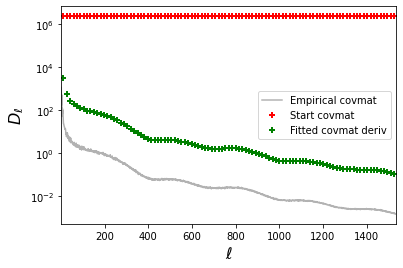

In [40]:
#### PLOT OF BEST-FIT ####

cov_opti_deriv = cl_mod.eval(**param_optimised_deriv)
i=5 #freq to plot
plt.figure()
plt.plot(ell,emp_cov[i,i,:],alpha = .3, c = 'k', label = 'Empirical covmat')
plt.scatter(ell_mean,mat_start[i,i,:],lw=2, c = 'r', label = 'Start covmat', marker = '+')
plt.scatter(ell_mean,np.abs(cov_opti_deriv[i,i,:]),lw=2, c = 'g', label = 'Fitted covmat deriv', marker = '+')
plt.yscale('log')

plt.xlabel('$\ell$', fontsize=16)
plt.xlim(2,lmax)
plt.ylabel('$D_\ell$', fontsize =16)
# plt.yscale('log')
plt.legend()
plt.show()